# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!nvidia-smi

Wed Dec 14 22:36:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 49%   59C    P0    50W / 200W |   1003MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import os
from imageio.v2 import imread
from PIL import Image, ImageFilter, ImageEnhance
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
# tf.set_random_seed(30) # deprecated
tf.random.set_seed(30)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
project_folder='Project_data'

## Configration

In [5]:
train_doc = np.random.permutation(open(f'{project_folder}/train.csv').readlines())
val_doc = np.random.permutation(open(f'{project_folder}/val.csv').readlines())
batch_size = 10 #experiment with the batch size
image_count = 30 # number of images to be used for each video
image_height=160
image_width=160
channels=3
num_classes=5 # number of classes
input_shape=(image_count,image_width,image_height,channels)
curr_dt_time = datetime.datetime.now()
train_path = f'{project_folder}/train'
val_path = f'{project_folder}/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs  
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[x for x in range(0,image_count)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size    # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,image_count,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,image_count,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,GRU,GlobalAveragePooling2D,LSTM,MaxPool2D,ConvLSTM2D,GlobalAveragePooling1D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import MobileNet

### First / Second Experiment

In [8]:
# model = Sequential()
# model.add(Conv3D(16, (3, 3, 3), padding='same',
#           input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(64,activation='relu'))

# model.add(Dense(num_classes,activation='softmax'))

### Third / Fourth Experiment

In [9]:
# model = Sequential()
# model.add(Conv3D(16, (3, 3, 3), padding='same',
#           input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (7, 7, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))

# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(64,activation='relu'))

# model.add(Dense(num_classes,activation='softmax'))

### Fifth Experiment

In [10]:
# model = Sequential()
# model.add(Conv3D(16, (3, 3, 3), padding='same',
#           input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (7, 7, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))

# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(64,activation='relu'))

# model.add(Dense(num_classes,activation='softmax'))

### Sixth Experiment

In [11]:
# model = Sequential()
# model.add(Conv3D(32, (3, 2, 3), padding='same',
#           input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 3, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (7, 1, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(num_classes,activation='softmax'))

### Seventh Experiment

In [12]:
# model = Sequential()
# model.add(Conv3D(32, (3, 3, 3), padding='same',
#           input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (7, 7, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512,activation='relu'))
# model.add(Dense(256,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(num_classes,activation='softmax'))

### Eighth Experiment

In [13]:
# model = Sequential()
# model.add(Conv3D(32, (3, 3, 3), padding='same',
#           input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (7, 7, 7), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512,activation='relu'))
# model.add(Dense(256,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(num_classes,activation='softmax'))

### Nineth Experiment

In [14]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(num_classes, activation='softmax'))

### Tenth Experiment

In [15]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

### Eleventh Experiment

In [16]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GRU(64))
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

### Twelfth Experiment

In [17]:
from keras.applications import ResNet152V2
# EfficientNetB7 with rnn gru units
model = Sequential()
model.add(TimeDistributed(ResNet152V2(weights='imagenet', include_top=False),input_shape=input_shape, name='ResNet152V2', trainable=False))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(GRU(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
callbacks_list = [checkpoint, LR]

In [20]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ResNet152V2 (TimeDistribute  (None, 30, 5, 5, 2048)   58331648  
 d)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 30, 2048)         0         
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 64)           131136    
 tributed)                                                       
                                                                 
 dense_1 (Dense)             (None, 30, 256)           16640     
                                                                 
 batch_normalization (BatchN  (None, 30, 256)          1024      
 ormalization)                                          

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
# history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=4, initial_epoch=0,max_queue_size=20)

# fit_generator is deprecated and will be removed in a future version. Using fit which supports generators.
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list,
                  validation_data=val_generator, validation_steps=validation_steps, class_weight=None,
                  workers=1, initial_epoch=0,max_queue_size=3000)

Source path =  Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 2.8265 - categorical_accuracy: 0.4600Source path =  Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-12-1422_37_00.899527\model-00001-2.82650-0.46003-2.93086-0.41000.h5
67/67 [==============================] - 108s 1s/step - loss: 2.8265 - categorical_accuracy: 0.4600 - val_loss: 2.9309 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 3.0478 - categorical_accuracy: 0.5572
Epoch 2: saving model to model_init_2022-12-1422_37_00.899527\model-00002-3.04783-0.55721-4.62775-0.40000.h5
67/67 [==============================] - 36s 534ms/step - loss: 3.0478 - categorical_accuracy: 0.5572 - val_loss: 4.6277 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 3.3134 - categorical_accuracy: 0.5721
Epoch 3: saving model to m

<Figure size 1000x1000 with 0 Axes>

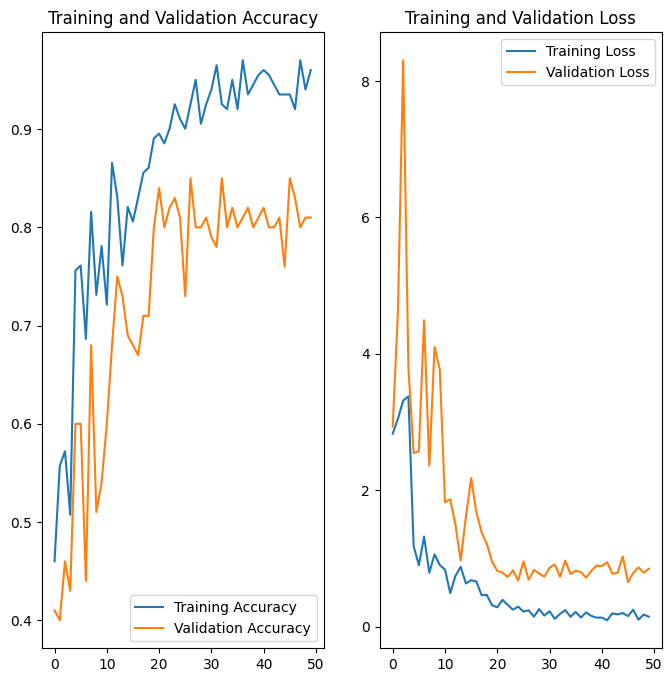

In [23]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Note: Saved running of the best model generated in the 8th experiment

### Loading best model and evaluating on validation data

In [24]:
from keras.models import load_model
 
# load model
model = load_model('model-00046-0.12084-0.96241-0.07147-1.00000.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 158, 158, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 26, 156, 156, 64)  55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 13, 78, 78, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 78, 78, 64)   256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 13, 78, 78, 64)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 11, 76, 76, 128)   2

In [27]:
# Evaluate on Validation data
scores = model.evaluate(val_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

100/100 [==============================] - 66s 663ms/step - loss: 0.0971 - categorical_accuracy: 0.9800
evaluate categorical_accuracy: 98.00%
